In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import math
from pcygni_8 import PcygniCalculator
from scipy.interpolate import interp1d
import astropy.units as units
import astropy.constants as csts

pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
def forbidden(ax): 
    top = 10
    #define telluric region
    ax.fill_between([13100, 14400], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.6 )
    ax.fill_between([17550, 19200], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.6 )

    #poorly constrained regions
    ax.fill_between([5330, 5740], [-5*10**(-16)*fac, -5*10**(-16)*fac] , [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.3   )
    ax.fill_between([9940, 10200], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.3  )

    #define absorbtion feature
    #ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
    ax.fill_between([3000, 4000], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.3  )


In [34]:
from astropy.modeling import models
import numba

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, ratio_vel = 1, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA, ratio_vel = ratio_vel)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=20 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32, 
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653, ratio_vel = 1): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel = ratio_vel)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, ratio_vel=ratio_vel)
    
    if data is None:
        return model
    return (model - data)/error

def residual_p_cygni(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]

    
    intensity = temp(wav, T)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = N*intensity*(correction-1)
    
    if data is None:
        return intensity
    return (model - data)/error


import lmfit

beta, doppler = np.loadtxt('doppler_wo_prolate_inv.txt')
inter = interp1d(beta, doppler)

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 

    delta = inter(vphot) #1-2/3*11/10*vphot
    corr = delta**4
        
    #theta = 2*np.sqrt( N*10**(7) /(1-vphot)*corr )#**5)/np.pi ) #regular
    theta = 2*np.sqrt( N*10**(7) / corr )#**5)/np.pi ) #inverse

    v = vphot*c 
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23) 
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]
fac = 1e16

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


((3500.0, 22300.0), (0.0, 3e-16))

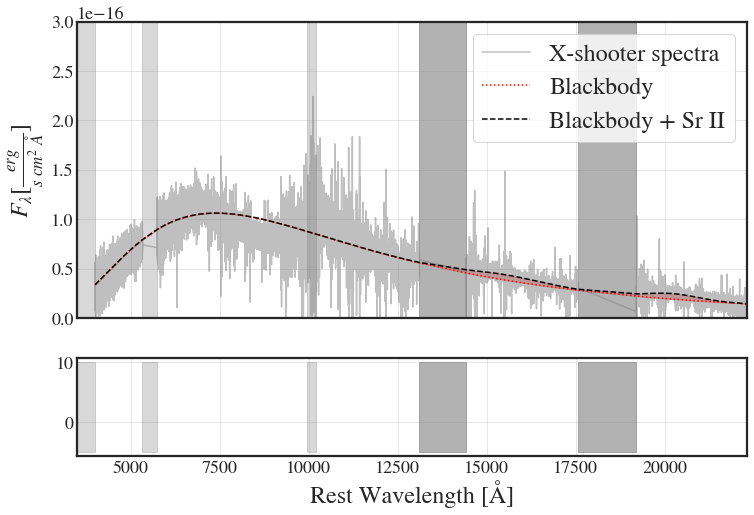

In [35]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8),nrows=2, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

#fit_res = ["./data/OB1/OB1_low_v.pkl", "./data/OB2/OB2_vphot_33.pkl", 
#           "./data/OB3_init_no_gaussian_high_v.pkl"]

#OB1_3_peaks_assym_20x10000
fit_res = ["./data/OB1/OB1_3_peaks_assym_20x50000_l2.pkl", "./data/OB2/OB2_3_peaks_assym_20x30000.pkl", 
        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl", "./Data/OB5/OB5_3_peaks_XL.pkl"] 

for i in [1]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl, flux, error = x[:,0], x[:,1], x[:,2]
    exc_reg_2 = (x[:,0] > 4000) & (x[:,0] < 22500) & \
        (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) #& (~((x[:,0] > 9840) & (x[:,0] < 10300))) 
    wl2, flux2, error2 = wl[exc_reg_2], flux[exc_reg_2], error[exc_reg_2] # bin_spectrum(wl, flux, error, ~exc_reg_2, 10)

pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
#emcee_res.params['ratio_vel'].value=1
emcee_res.params['tau'].value=0
flux_fit = residual(emcee_res.params, wl2*1e-10)
flux_fit_bb = bb( wl2*1e-10, emcee_res.params['T'], emcee_res.params['N'])

#ratio = (flux2-flux_fit)/(flux_fit)

ax[0].plot(wl2, flux2, #[(ratio < .5) & (ratio>-0.5)], flux2[(ratio < .5) & (ratio>-0.5)], 
              label='X-shooter spectra', color='grey', alpha=0.5)#, s=1)
ax[0].plot(wl2, flux_fit_bb, color='red', ls='dotted', label='Blackbody')
ax[0].plot(wl2, flux_fit, color='k', ls='--', label='Blackbody + Sr II')
ax[0].fill_between(wl2, flux_fit, flux_fit_bb, color='red', alpha=0.3)

#ax[1].plot(wl2[(ratio < .5) & (ratio>-0.5)], (flux2-flux_fit)[(ratio < .5) & (ratio>-0.5)], 
#           color='grey', ls='-', label='Blackbody + Sr II')
#ax[1].set_ylim(-0.5e-16,0.5e-16), ax[1].set_ylabel('Residual')

plt.xlabel('Rest Wavelength [Å]'), ax[0].set_ylabel(r'$F_{\lambda}   [ \frac{erg}{s \ cm^2 \ Å} ] $'), 
plt.ticklabel_format(axis='x', style='plain')
forbidden(ax[0]), ax[0].legend(frameon=True)
forbidden(ax[1])

#plt.xscale('log') 
plt.xlim(3500,22300), ax[0].set_ylim(0, 3e-16), 
#plt.savefig('Pictures/5th_Epoch.png', dpi=300)

#ax[0].axvline(7600)
#ax[0].axvline(7900)


In [36]:
### Make binned spectrum

In [37]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

reset_plt(18,24)

#fit_res = ["./data/OB1/OB1_low_v.pkl", "./data/OB2/OB2_vphot_33.pkl", 
#           "./data/OB3_init_no_gaussian_high_v.pkl"]
fit_res = ["./data/OB1/OB1_3_peaks_assym_20x10000.pkl", "./data/OB2/OB2_3_peaks_assym_20x30000.pkl", 
        "./data/OB3/OB3_3_peaks_XL.pkl", "./Data/OB4/OB4_3_peaks_XL.pkl", "./Data/OB5/OB5_3_peaks_XL.pkl"] 

for i in [1]: 
    x = np.loadtxt(path+'/'+files[i]).T
    wl, flux, error = x[:,0], x[:,1], x[:,2]
    exc_reg_2 = (x[:,0] > 4000) & (x[:,0] < 22500) & \
        (~((x[:,0] > 13100) & (x[:,0] < 14400))) & (~((x[:,0] > 17550) & (x[:,0] < 19200))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) #& (~((x[:,0] > 9840) & (x[:,0] < 10300))) 
    wl3, flux3, error3,_ = bin_spectrum(wl, flux, error, ~exc_reg_2, 200)

pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params['tau'].value=0
flux_fit_3 = residual(emcee_res.params, wl3*1e-10)
flux_fit_bb = bb( wl2*1e-10, emcee_res.params['T'], emcee_res.params['N'])

Binning image by a factor: 200


<ipython-input-37-63415d896c86>:110: RuntimeWarning: divide by zero encountered in long_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
<ipython-input-37-63415d896c86>:110: RuntimeWarning: invalid value encountered in double_scalars
  average = (1 / n) * np.sum(flux_func, axis = axis)
<ipython-input-37-63415d896c86>:112: RuntimeWarning: divide by zero encountered in long_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
<ipython-input-37-63415d896c86>:112: RuntimeWarning: invalid value encountered in double_scalars
  variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one 

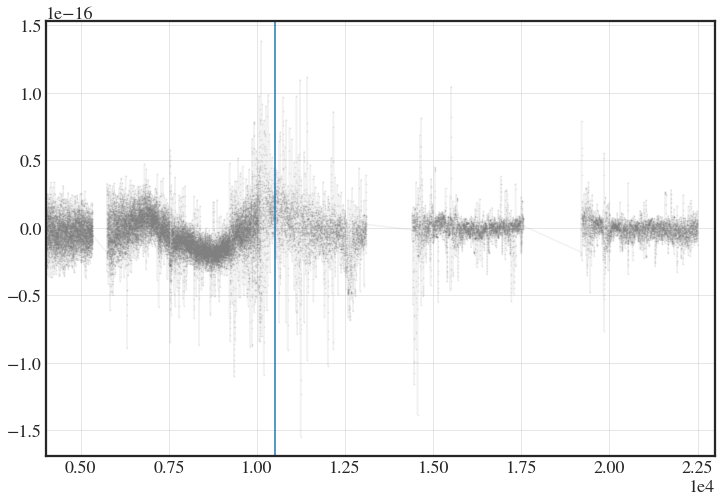

In [21]:
reset_plt(18,24)
fig,ax = plt.subplots(figsize=(12,8))
#plt.plot(wl2, flux_fit)
plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.1, s=1)
plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.1)
plt.xlim(4000,23000), plt.ylim()

plt.axvline(10500)


In [38]:
import time
emcee_res.params['t0'].value


212400

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


4.487820386886597


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

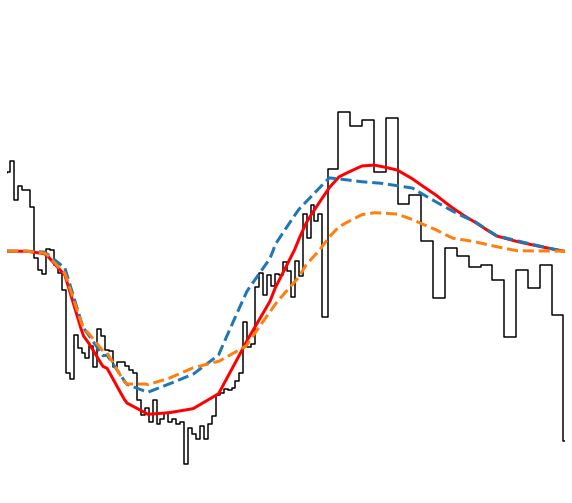

In [32]:
pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params['ratio_vel'].value = 1.0001


start = time.time()
flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
end = time.time()
print(end - start) 



reset_plt(21,28)
fig,ax = plt.subplots(figsize=(10,9))
#plt.plot(wl2, flux_fit)
#plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.15, s=1)
#plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.1, label='X-shooter Spectra')
plt.step(wl3, flux3-flux_fit_3, alpha=1, color='k', where='mid', label='Binned X-Shooter Spectra')
plt.plot(wl2, (flux_fit2), color='red', label='$v_{line, \perp}=v_{line,\parallel}$', linewidth=3)


if True:
    emcee_res.params['ratio_vel'].value=0.95 
    #emcee_res.params['vphot'].value *= 0.9
    #emcee_res.params['vmax'].value  *= 0.9
    
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=0.95 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')

    #emcee_res.params['vphot'].value *= 1.1**2
    emcee_res.params['ratio_vel'].value=1.05
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=1.05 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')
    
plt.xlim(6900,12500), plt.ylim(-2.5e-17,2.5e-17)
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'Blackbody Residual $ [ \frac{erg}{s \ cm^2 \ Å} ] $')

#plt.legend(frameon=True, fontsize=20, loc=2, ncol=2)

import seaborn as sb
sb.despine(fig,ax, left=True, bottom=True)
plt.xticks([]), plt.yticks([])
plt.xlabel(''), plt.ylabel('')

plt.savefig('Pictures/asymmetry_lines_2_epoch_no_ax.png', dpi=300)

1.2192087173461914


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

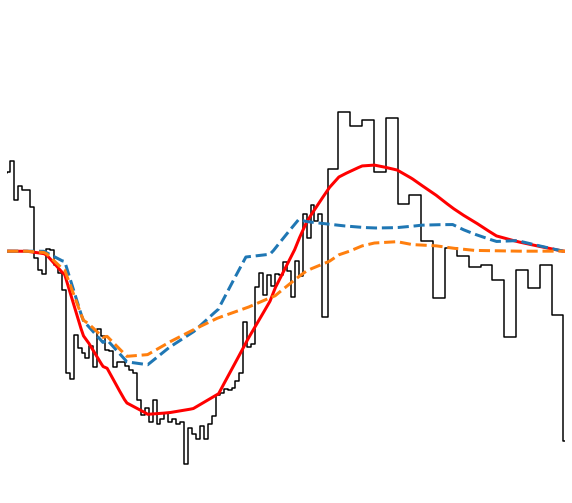

In [39]:
pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params['ratio_vel'].value = 1.0001


start = time.time()
flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
end = time.time()
print(end - start) 



reset_plt(21,28)
fig,ax = plt.subplots(figsize=(10,9))
#plt.plot(wl2, flux_fit)
#plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.15, s=1)
#plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.1, label='X-shooter Spectra')
plt.step(wl3, flux3-flux_fit_3, alpha=1, color='k', where='mid', label='Binned X-Shooter Spectra')
plt.plot(wl2, (flux_fit2), color='red', label='$v_{line, \perp}=v_{line,\parallel}$', linewidth=3)


if True:
    emcee_res.params['ratio_vel'].value=0.9 
    #emcee_res.params['vphot'].value *= 0.9
    #emcee_res.params['vmax'].value  *= 0.9
    
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=0.95 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')

    #emcee_res.params['vphot'].value *= 1.1**2
    emcee_res.params['ratio_vel'].value=1.1
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=1.05 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')
    
plt.xlim(6900,12500), plt.ylim(-2.5e-17,2.5e-17)
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'Blackbody Residual $ [ \frac{erg}{s \ cm^2 \ Å} ] $')

#plt.legend(frameon=True, fontsize=20, loc=2, ncol=2)

import seaborn as sb
sb.despine(fig,ax, left=True, bottom=True)
plt.xticks([]), plt.yticks([])
plt.xlabel(''), plt.ylabel('')

plt.savefig('Pictures/asymmetry_lines_2_epoch_no_ax.png', dpi=300)

0.06907820701599121


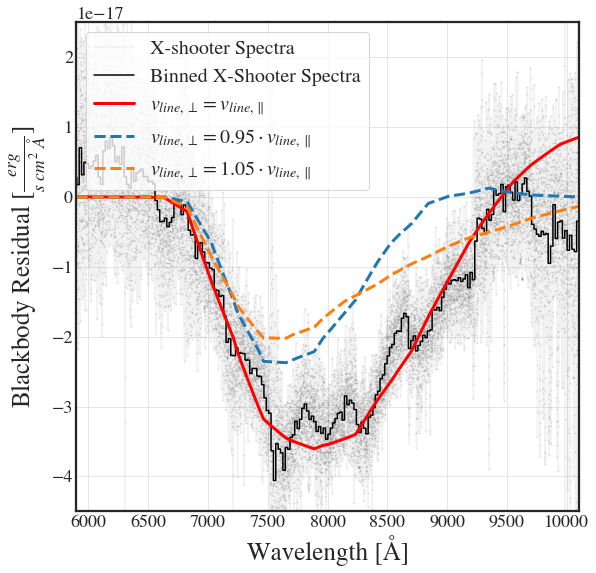

In [43]:
pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params['ratio_vel'].value = 1.0001
emcee_res.params['occult'].value = 1.0001


start = time.time()
flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
end = time.time()
print(end - start) 



reset_plt(18,25)
fig,ax = plt.subplots(figsize=(9,9))
#plt.plot(wl2, flux_fit)
plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.15, s=1)
plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.1, label='X-shooter Spectra')
plt.step(wl3, flux3-flux_fit_3, alpha=1, color='k', where='mid', label='Binned X-Shooter Spectra')
plt.plot(wl2, (flux_fit2), color='red', label='$v_{line, \perp}=v_{line,\parallel}$', linewidth=3)


if True:
    emcee_res.params['ratio_vel'].value=0.8 
    #emcee_res.params['vphot'].value *= 0.9
    #emcee_res.params['vmax'].value  *= 0.9
    
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=0.95 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')

    #emcee_res.params['vphot'].value *= 1.1**2
    emcee_res.params['ratio_vel'].value=1.2
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=1.05 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')
    
plt.xlim(5900,10100), plt.ylim(-4.5e-17,2.5e-17)
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'Blackbody Residual $ [ \frac{erg}{s \ cm^2 \ Å} ] $')
plt.legend(frameon=True, fontsize=20, loc=2)

#plt.savefig('Pictures/asymmetry_lines_n_epoch_3.png', dpi=300)

0.06908512115478516


Text(0, 0.5, 'Blackbody Residual $ [ \\frac{erg}{s \\ cm^2 \\ Å} ] $')

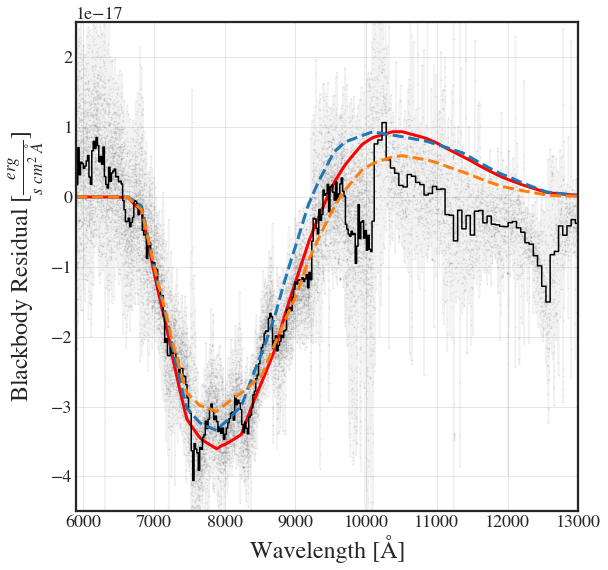

In [24]:
pickle_in = open(fit_res[i],"rb")
emcee_res = pickle.load(pickle_in)
emcee_res.params['occult'].value=1
emcee_res.params['ratio_vel'].value = 1.0001


start = time.time()
flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
end = time.time()
print(end - start) 



reset_plt(18,24)
fig,ax = plt.subplots(figsize=(9,9))
#plt.plot(wl2, flux_fit)
plt.scatter(wl2, flux2-flux_fit, color='grey', alpha=0.1, s=1)
plt.plot(wl2, flux2-flux_fit, color='grey', alpha=0.1, label='X-shooter Spectra')
plt.plot(wl2, (flux_fit2), color='red', label='$v_{\parallel}=v_\perp$', linewidth=3)

plt.step(wl3, flux3-flux_fit_3, alpha=1, color='k', where='mid', label='Binned X-Shooter Spectra')

if True:
    emcee_res.params['ratio_vel'].value=0.95 
    #emcee_res.params['vphot'].value *= 0.9
    #emcee_res.params['vmax'].value  *= 0.9
    
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{phot}=0.95 \cdot v_\perp$', linewidth=3)#, color='red')

    #emcee_res.params['vphot'].value *= 1.1**2
    #emcee_res.params['vmax'].value  *= 1.1**2
    
    emcee_res.params['ratio_vel'].value=1.05
    flux_fit2 = residual_p_cygni(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', label='$v_{phot}=1.05 \cdot v_\perp$', linewidth=3)#, color='red')
    
plt.xlim(5900,13000), plt.ylim(-4.5e-17,2.5e-17)
plt.ticklabel_format(axis='x', style='plain')
plt.xlabel('Wavelength [Å]')
plt.ylabel(r'Blackbody Residual $ [ \frac{erg}{s \ cm^2 \ Å} ] $')
#plt.legend(frameon=True, fontsize=18, loc=2)

#plt.savefig('Pictures/asymmetry_lines_n_epoch_2.png', dpi=300)

In [12]:
flux_fit2

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
import scipy.integrate as integ
import numba 
import scipy

@numba.njit
def function(x, y, z, vmax, vphot, t, vdet_min, vdet_max, tauref, ve, ratio_vel): 
    return 1
pmax=1

@numba.cfunc(numba.f8(numba.i4,numba.types.CPointer(numba.f8)))
def get_Iemit(n, ptr):
    temp = numba.carray(ptr, n)

    vmax, vphot, t, vdet_min, vdet_max, tauref, ve, ratio_vel = np.float32(temp[3]), np.float32(temp[4]), np.float32(temp[5]),\
          np.float32(temp[6]), np.float32(temp[7]), np.float32(temp[8]), np.float32(temp[9]), np.float32(temp[10])
    return function(np.float32(temp[0]), np.float32(temp[1]), np.float32(temp[2]), vmax, vphot, t, vdet_min, vdet_max, tauref, ve, ratio_vel)
    
args = (1, 2, 3, 4, 5, 6, 7, 8, 9)
_Iemit = scipy.LowLevelCallable(get_Iemit.ctypes)


In [14]:
Fnu  = 4*integ.dblquad(function, 0, pmax, lambda x: 0, lambda x: (pmax**2-x**2)**(1/2), args=args, epsabs=1)[0]
print(Fnu)

3.14161975053083


In [15]:
np.arctan(1000)

1.5697963271282298